## **0. Get Setup**

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision

from torch import nn
from torchvision import transforms

# Importing torchinfo
try:
  from torchinfo import summary
except:
  print("Couldn't find torchinfo... installing it.")
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("Couldn't find going_modular scripts... downloading them from Github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

Couldn't find torchinfo... installing it.
Couldn't find going_modular scripts... downloading them from Github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## **1. Get Data**

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Path to data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzipping the folder
  with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path/"pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [ ]:
train_dir = image_path/"train"
test_dir = image_path/"test"

In [ ]:
import torchvision
torchvision.__version__

'0.21.0+cu124'

## **2. Create Datasets and DataLoaders**

### Creating transform for `torchvision.models`

In [ ]:
# Creating a transform pipeline manually
manual_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # Turn image values between 0 & 1
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean across each colour channel
                                                            std=[0.229, 0.224, 0.225]) # A standard deviation across each colour channel
                                       ])

# Creating training and testing DataLoaders as well as getting a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8710886050>,
 ['pizza', 'steak', 'sushi'])

creating a transform for pretrained model (auto creation)

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT - best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f871088fdd0>,
 ['pizza', 'steak', 'sushi'])

## **3. Getting pretrained model**

In [ ]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 112MB/s]


In [ ]:
# Printing a summary using torchinfo for the model
summary(model=model,
        input_size=(32, 3, 224, 224), # "input_size" not "input_shape"
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### Freezing the base model and changing the output layer to suitability
Freeze some base layer of a pretrained model and then ajust the output layers to suit your needs.

This is by setting the attribute `requires_grad=False`. PyTorch doesn't track gradient updates and in turn these parameters won't be changed by the optimizer during training.

In [ ]:
# Freeze the feature extractor by setting requires_grad=False
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

output_shape = len(class_names)

# Recreate the classifier layer and send it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [ ]:
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## **4. Training the model**

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)
# torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_time = timer()

print(f"Total training time {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
Total training time 154.242 seconds


## **5. Evaluate model by plotting curves**


helper_functions.py file was not found, downloading it...


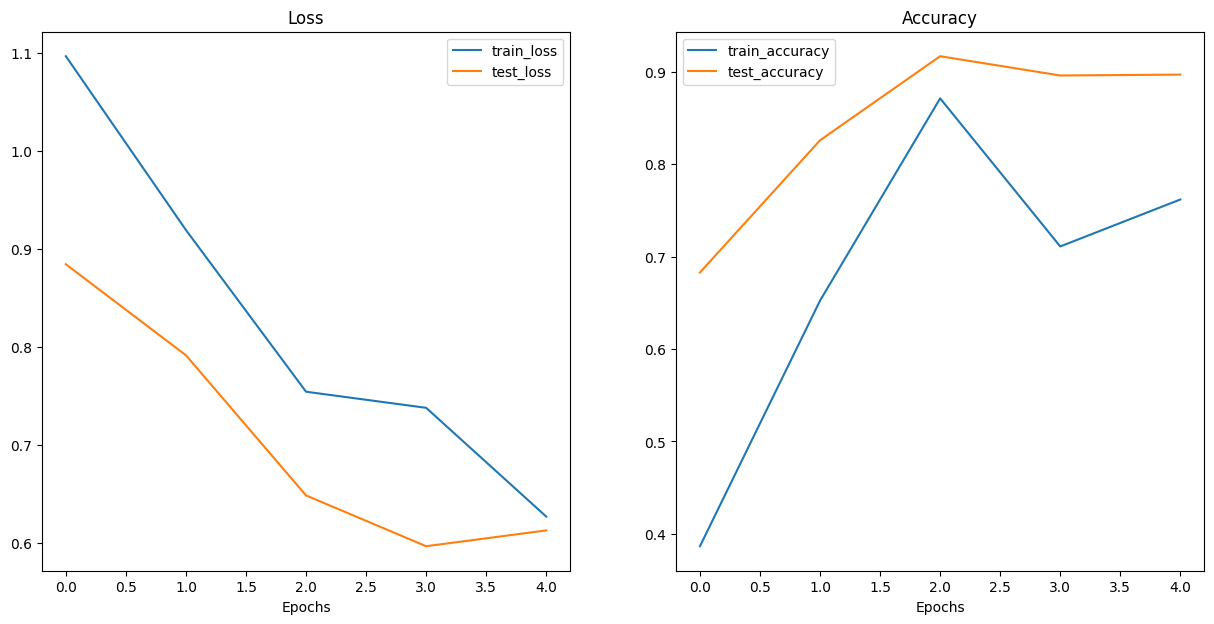

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py script
try:
  from helper_functions import plot_loss_curves
except:
  print("helper_functions.py file was not found, downloading it...")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of the model
plot_loss_curves(results)

## **6.Make predictions on the images from the test set**
The images will have to have:

- Same shape
- Same datatype
- Be on same device
- Same transformations

As per the model.

In [ ]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class_names, image_path, image_size, a transform and target device
def pred_and_plot_image(model:nn.Module,
                        image_path:str,
                        class_names:List[str],
                        image_size:Tuple[int, int] = (224, 224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device):
  # 2. Open image
  img = Image.open(image_path)

  # 3. Create transformation for image (if it doesn't exist)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])

  # **PREDICT ON IMAGE**
  # 4. Make sure the model is on target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add extra dimension to image
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make prediction on image with an extra dimension and send it to target device
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> prediction probs (torch.softmax() for multiclass classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert prediction probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot image with predicted label and probabilities
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

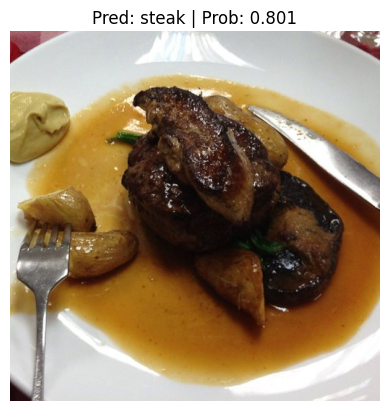

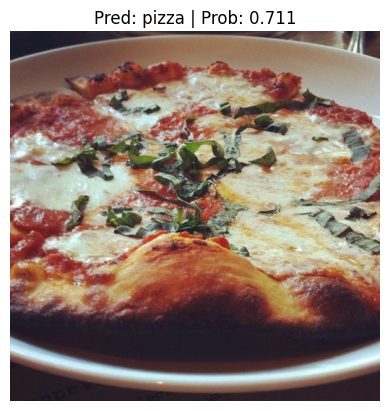

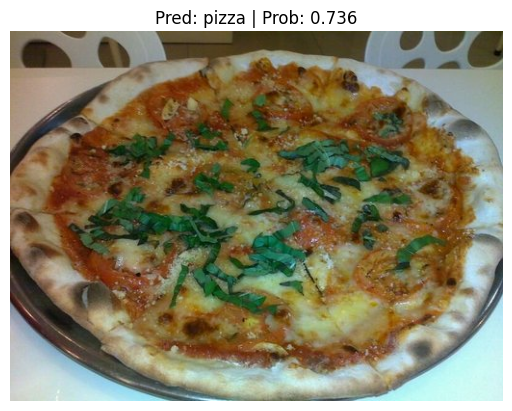

In [ ]:
# Get random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list of all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred & plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      # transform=weights.transforms(), # from pretrained model weights (optional)
                      image_size=(224, 224))

### ***Making predictions on a custom image***

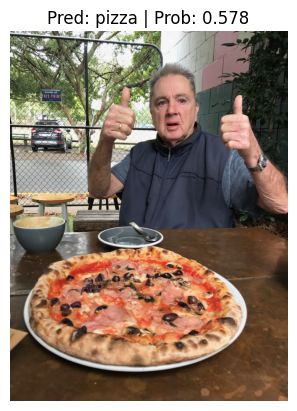

In [ ]:
# Download custom image
custom_image_path = data_path/ "pizza-guy.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists!")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

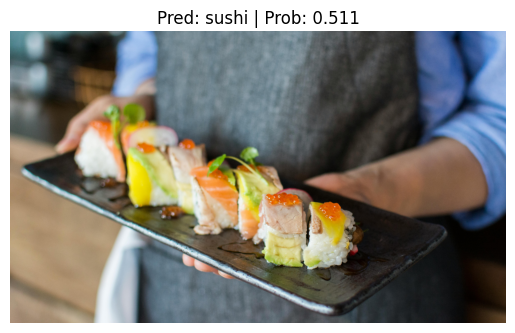

In [ ]:
import requests
from pathlib import Path

# Setup data path and image path
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)
custom_image_path = data_path / "rando-chef-holding-sushi.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://images.pexels.com/photos/1422384/pexels-photo-1422384.jpeg?cs=srgb&dl=pexels-huy-phan-316220-1422384.jpg&fm=jpg")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists!")

# Predict on the custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)


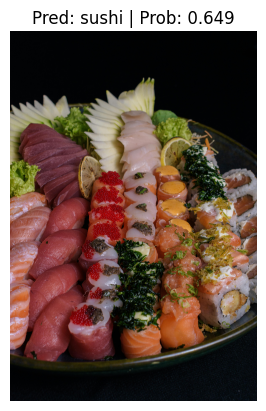

In [ ]:
import requests
from pathlib import Path

# Setup data path and image path
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)
custom_image_path = data_path / "plate-of-sushi.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://images.pexels.com/photos/31264148/pexels-photo-31264148.jpeg?cs=srgb&dl=pexels-caio-pezzo-1758169-31264148.jpg&fm=jpg")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists!")

# Predict on the custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)